# Projet CNN : Qui a peint ce tableau ?

## 1) Chargement des librairies

In [3]:
import os, sys, math
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from skimage.transform import resize

2024-10-17 17:03:49.853121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 17:03:50.696546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 17:03:51.043692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 17:03:53.484653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 17:03:59.682964: W tensorflow/compiler/tf2

## 2) Chargement des données

In [4]:
# Chemin des données
chemin = os.getcwd()
chemin = os.path.join(chemin, "art-challenge", "images_lq")

# Mise en forme de data
data = []
for fichier in os.listdir(chemin):
    artiste = '_'.join(fichier.split('_')[:-1])
    image = plt.imread(os.path.join(chemin, fichier))
    data.append([image, artiste])

Parmi les différentes peintures, certaines sont en noir et blanc et d'autres sont en couleurs. Nous devons donc faire en sorte que toutes les images soient sous le même format. Nous avons choisi de toutes les mettre en RGB, donc avec 3 canaux de couleur pour chaque pixel.

In [5]:
# Conversion des images en RGB
data_rgb = []
for image, artiste in data:
        # L'image est en niveaux de gris
        if len(image.shape) == 2:
            image_rgb = np.stack((image,) * 3, axis = -1)
        # L'image est déjà en RGB
        else:
            image_rgb = image
        data_rgb.append([image_rgb, artiste])

In [6]:
print("Dimensions avant transformation : ", data[0][0].shape)
print("Dimensions après transformation : ", data_rgb[0][0].shape)

Dimensions avant transformation :  (614, 432)
Dimensions après transformation :  (614, 432, 3)


In [7]:
def afficher_images(data, nombre_images):
    images_aleatoires = rd.sample(data, nombre_images)
    plt.figure(figsize = (15, 5))
    for i, (image, artiste) in enumerate(images_aleatoires):
        plt.subplot(1, nombre_images, i + 1)
        plt.imshow(image)
        plt.title(artiste)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

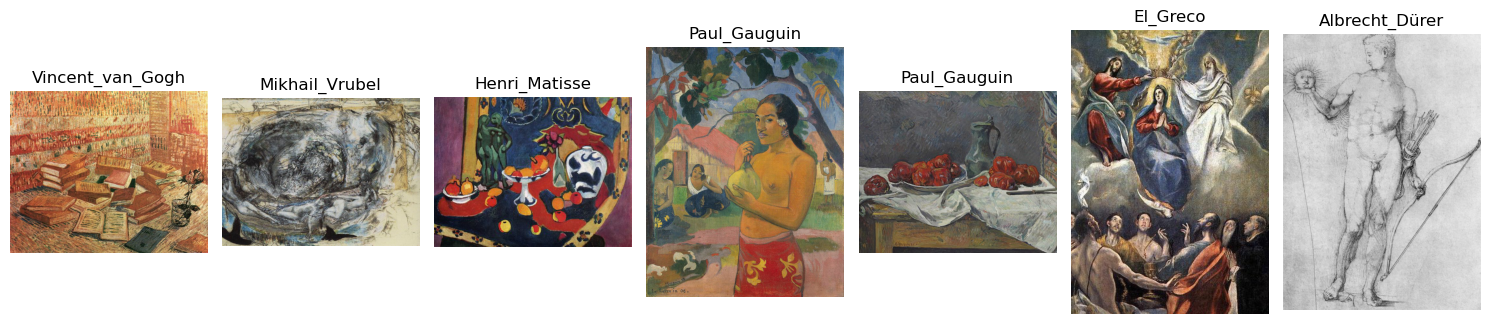

In [12]:
afficher_images(data_rgb, 7)

## 3) Analyse exploratoire des données

Dans un premier temps, observons la répartition du nombre de peintures pour chaque artiste pour voir si la base de données est équilibrée.

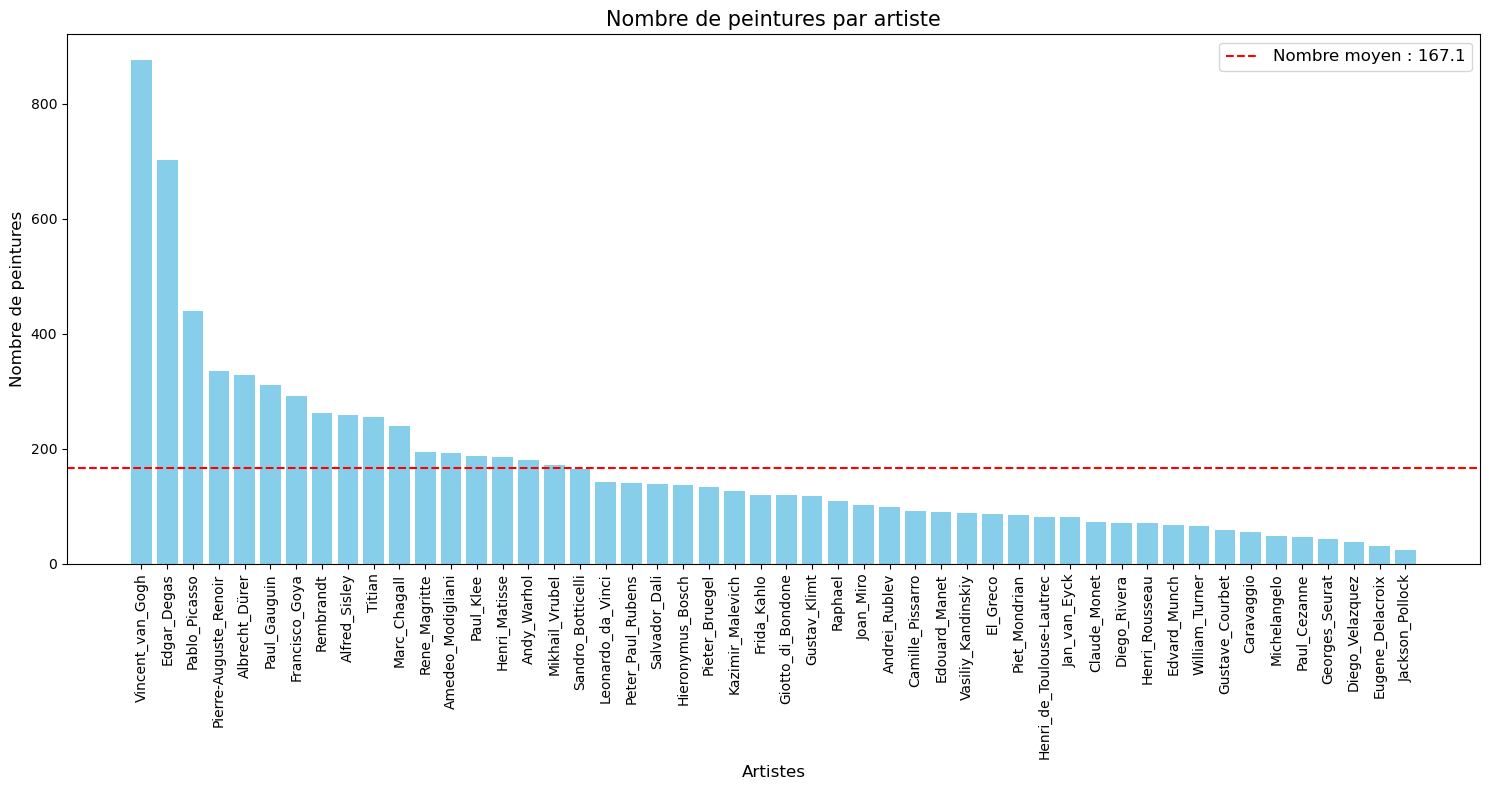

In [52]:
# Récupération du nombre de peintures par artiste
dictionnaire_artistes = {}
for _, artiste in data_rgb:
    if artiste in dictionnaire_artistes:
        dictionnaire_artistes[artiste] += 1
    else:
        dictionnaire_artistes[artiste] = 1

# Trie le dictionnaire par nombre décroissant de peintures
liste_triée_artistes = sorted(dictionnaire_artistes.items(), key = lambda x: x[1], reverse = True)
noms_artistes = [artiste for artiste, _ in liste_triée_artistes]
nombres_peintures = [nombre for _, nombre in liste_triée_artistes]
nombre_moyen = sum(nombres_peintures) / len(nombres_peintures)

# Création de l'histogramme
plt.figure(figsize = (15, 8))
plt.bar(noms_artistes, nombres_peintures, color = "skyblue")
plt.axhline(y = nombre_moyen, color = "red", linestyle = "--", label = "Nombre moyen : " + str(nombre_moyen))
# [WIP] ajouter un ligne pour le seuil
plt.xticks(rotation = 90, ha = "center")
plt.xlabel("Artistes", fontsize = 12)
plt.ylabel("Nombre de peintures", fontsize = 12)
plt.legend(fontsize = 12)
plt.title("Nombre de peintures par artiste", fontsize = 15)
plt.tight_layout()
plt.show()

On remarque que 3 peintres sont significativement plus plus représentés : Vincent Van Gogh, Edgar Degas et Pablo Picasso.


[WIP]
Il est donc judicieux d'utiliser une augmentation des données sur les autres peintres pour équilibrer le nombre de tableaux. De plus on peut retirer certains artistes faute de volume de données les concernant.

[WIP]
Determiner un seuil limite pour supprimer les artistes

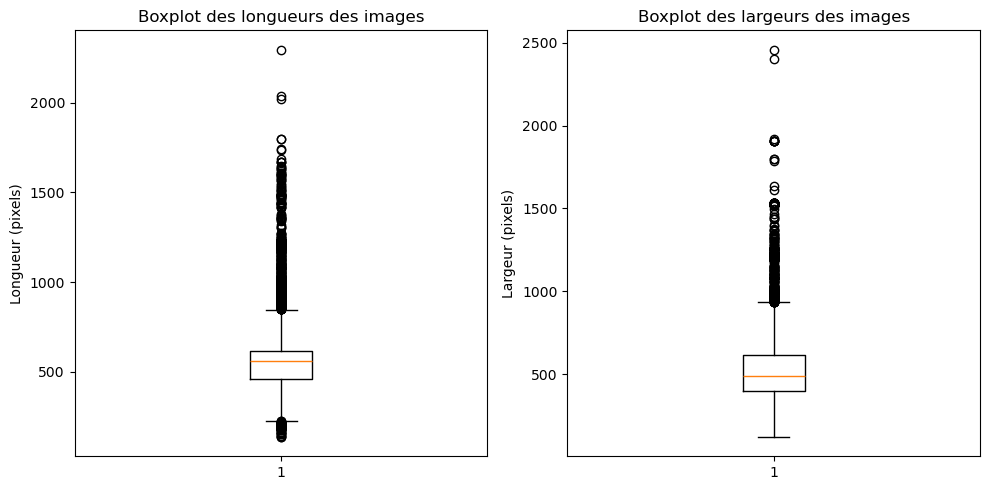

In [10]:
def boxplot_dimensions_images(data):
    """
    Affiche un boxplot des longueurs et des largeurs des images dans le dataset.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Extraire les longueurs et largeurs des images
    longueurs = [img.shape[0] for img, _ in data]  # Hauteur des images
    largeurs = [img.shape[1] for img, _ in data]   # Largeur des images

    # Créer un boxplot pour les longueurs
    plt.figure(figsize=(10, 5))

    # Boxplot pour les longueurs
    plt.subplot(1, 2, 1)
    plt.boxplot(longueurs)
    plt.title('Boxplot des longueurs des images')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs
    plt.subplot(1, 2, 2)
    plt.boxplot(largeurs)
    plt.title('Boxplot des largeurs des images')
    plt.ylabel('Largeur (pixels)')

    # Afficher les boxplots
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
boxplot_dimensions_images(data)


On va resize toutes les images en 512*512 (*3) A recheck après enlever des artistes.

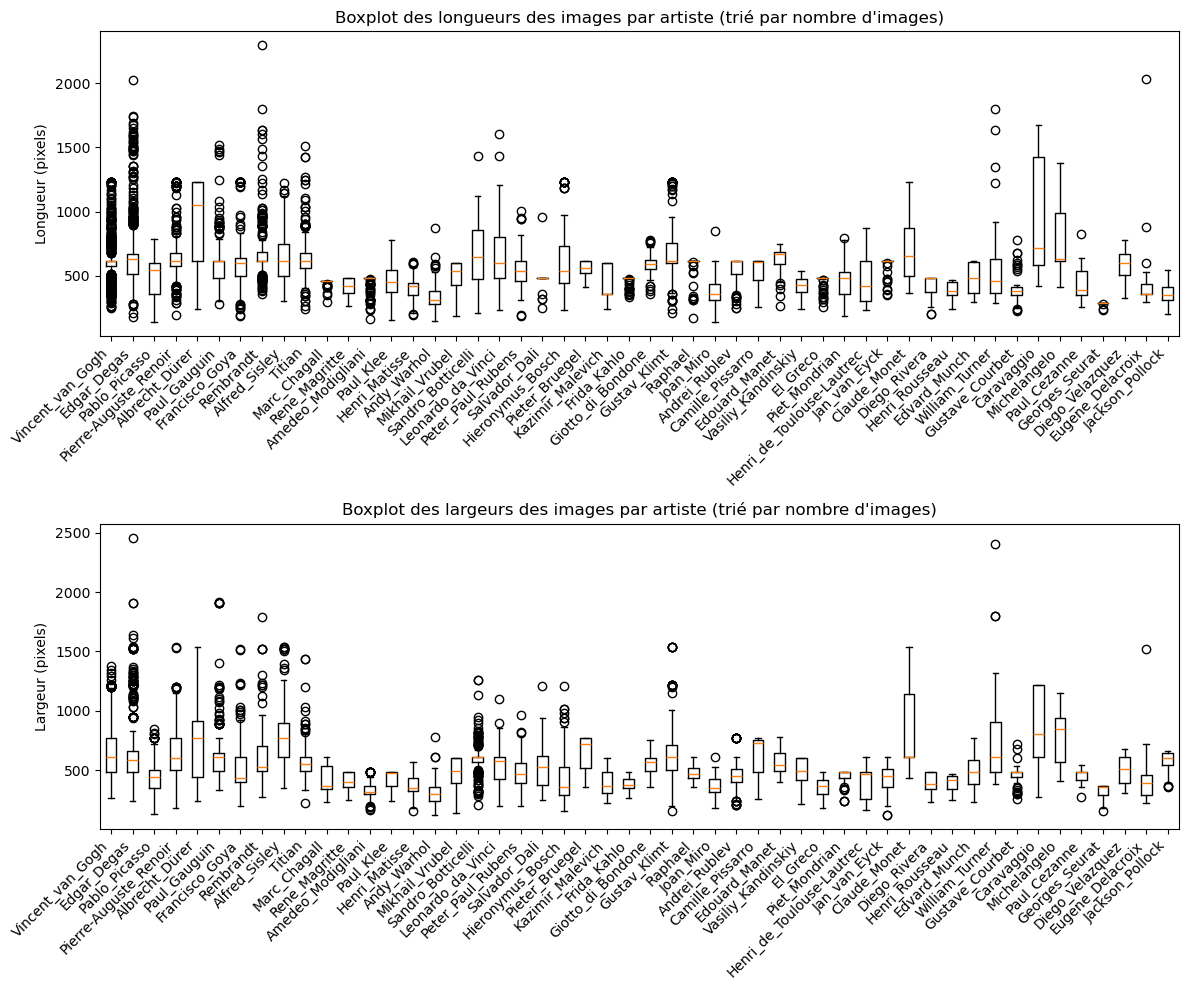

In [11]:
def boxplot_dimensions_par_artiste(data):
    """
    Affiche des boxplots des longueurs et largeurs des images pour chaque artiste, 
    trié par ordre décroissant du nombre d'images.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Initialiser des dictionnaires pour stocker les longueurs et largeurs par artiste
    longueurs_par_artiste = defaultdict(list)
    largeurs_par_artiste = defaultdict(list)

    # Parcourir les données pour remplir les longueurs et largeurs par artiste
    for img, artiste in data:
        longueurs_par_artiste[artiste].append(img.shape[0])  # Hauteur des images
        largeurs_par_artiste[artiste].append(img.shape[1])   # Largeur des images

    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter([artiste for _, artiste in data])

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    artistes = [artiste for artiste, _ in artistes_tries]

    # Récupérer les longueurs et largeurs triées par artiste
    longueurs = [longueurs_par_artiste[artiste] for artiste in artistes]
    largeurs = [largeurs_par_artiste[artiste] for artiste in artistes]

    # Créer une figure plus grande et étalée
    plt.figure(figsize=(12, 10))  # Augmenter la taille verticale

    # Boxplot pour les longueurs par artiste (en haut)
    plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, 1er subplot
    plt.boxplot(longueurs, labels=artistes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des longueurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs par artiste (en bas)
    plt.subplot(2, 1, 2)  # 2 lignes, 1 colonne, 2e subplot
    plt.boxplot(largeurs, labels=artistes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des largeurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Largeur (pixels)')

    # Ajuster la disposition et afficher
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
boxplot_dimensions_par_artiste(data)

In [ ]:

def redimensionner_images(data, nouvelle_taille=(512, 512, 3)):
    """
    Redimensionne les images dans le dataset à une nouvelle taille.

    Args:
    - data: Liste contenant des paires [image, artiste].
    - nouvelle_taille: Tuple représentant la nouvelle taille (hauteur, largeur, canaux).
    
    Returns:
    - data_redimensionne: Liste contenant des paires [image redimensionnée, artiste].
    """
    data_redimensionne = []
    for img, artiste in data:
        img_redim = resize(img, nouvelle_taille, anti_aliasing=True)
        data_redimensionne.append([img_redim, artiste])
    
    return data_redimensionne

def afficher_images_aleatoires_avant_apres(data, data_redimensionne, nombre_images=5):
    """
    Affiche 5 images aléatoires avant et après redimensionnement avec leurs labels.

    Args:
    - data: Liste d'images originales et leurs labels.
    - data_redimensionne: Liste d'images redimensionnées et leurs labels.
    - nombre_images: Nombre d'images à afficher.
    """
    # Sélectionner des échantillons aléatoires dans la liste data
    indices_aleatoires = random.sample(range(len(data)), nombre_images)

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices_aleatoires):
        # Image et artiste avant redimensionnement
        img_originale, artiste = data[idx]
        # Image après redimensionnement
        img_redim, _ = data_redimensionne[idx]

        # Afficher l'image originale
        plt.subplot(2, nombre_images, i + 1)
        plt.imshow(img_originale)
        plt.title(f'Originale: {artiste}')
        plt.axis('off')

        # Afficher l'image redimensionnée
        plt.subplot(2, nombre_images, i + 1 + nombre_images)
        plt.imshow(img_redim)
        plt.title(f'Redimensionnée: {artiste}')
        plt.axis('off')

    # Afficher les images
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
data_redimensionne = redimensionner_images(data)
afficher_images_aleatoires_avant_apres(data, data_redimensionne)
